In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import copy

import scipy.io as io
import scipy.stats as stats
from scipy import signal
from scipy.stats import mode
from scipy.linalg import eig
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline
from matplotlib.animation import FuncAnimation
import seaborn as sns

from skimage import measure
from skimage.filters import gaussian

from impdar import *

In [2]:
#files on disk
green_image = '../images/nline5.png'
green_mat = '../data/nline5_migtk_cropped.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

In [3]:
print(data.shape)

data = data[0:5850, :]

print(data.shape)

(9468, 4991)
(5850, 4991)


### Data cropping thoughts:

Is there some way to make this automatic? For instance, Ben mentioned that we could look at the power of the bed, and then set some cutoff value. So look at the bed and say: what is the **minimum** value where this criteria is met? For flat beds, this would work well. But for not so flat beds, this could be problematic because you would not pick as many internal reflectors that dip down to follow the bed.

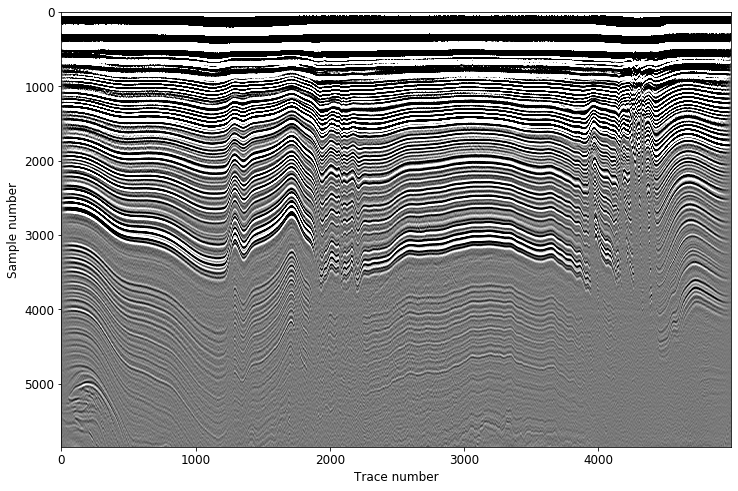

In [4]:
#original image
mini = -8.774235248565674
maxi = 9.667154026031533

fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=12)
plt.ylabel('Sample number', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Contouring

In [5]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [6]:
#save contours and their lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [7]:
#positive contours
for contour in pos:
    c_pos.append(contour)
print('Done!\n')

#negative contours
for contour in neg:
    c_neg.append(contour)
print('Done!\n') 

#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
print('Done!\n')
    
for contour in neg:
    c_length_neg.append(len(contour))
print('Done!\n')

Done!

Done!

Done!

Done!



In [8]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos_idx = list(np.where(np.array(c_length_pos) > 250)[0])
long_contours_neg_idx = list(np.where(np.array(c_length_neg) > 250)[0])

38
44400
298
30373


In [9]:
long_contours_pos = [pos[idx] for idx in long_contours_pos_idx]
long_contours_neg = [neg[idx] for idx in long_contours_neg_idx]

In [10]:
#isolate some contours
last_long_idx = long_contours_pos_idx[-30:]
last_long_contours = [pos[idx] for idx in last_long_idx]

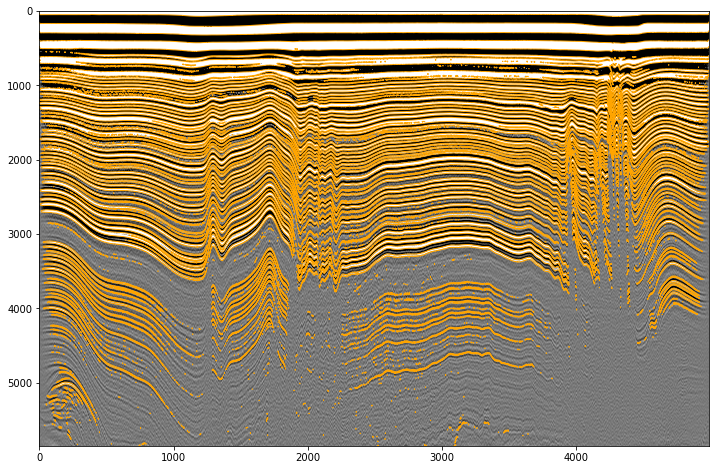

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for contour in pos:
    plt.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1)
    
plt.show()

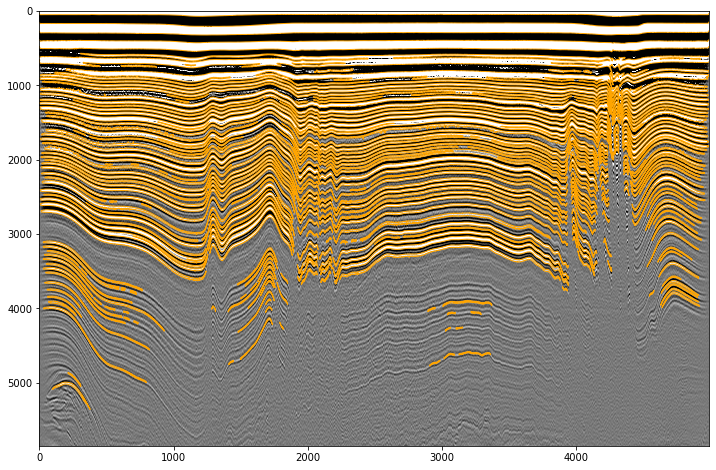

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for contour in long_contours_pos:
    plt.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1)
    
plt.show()

### find end points

In [11]:
z = 1
argx1 = np.argmin(last_long_contours[z][:, 1])
argx2 = np.argmax(last_long_contours[z][:, 1])

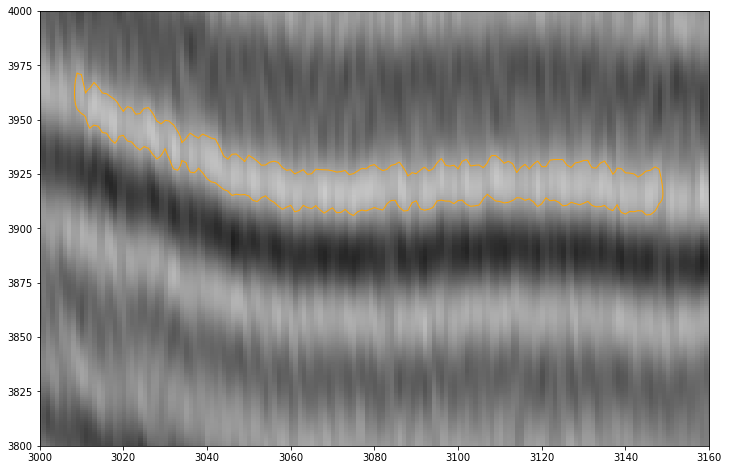

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

plt.xlim([3000, 3160])
plt.ylim([3800, 4000])

plt.show()

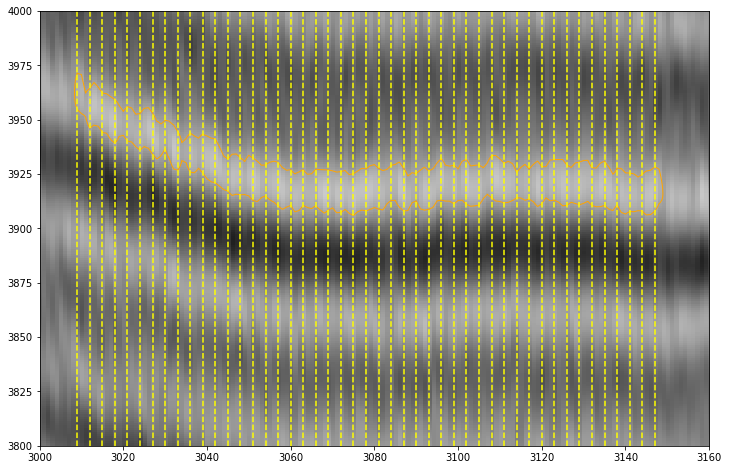

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

for x in range(int(np.around(last_long_contours[z][argx1, 1])), int(np.around(last_long_contours[z][argx2+1, 1])))[1::3]:
    ax.axvline(x=x, color='yellow', linestyle='--')

plt.xlim([3000, 3160])
plt.ylim([3800, 4000])
    
plt.show()

In [14]:
uniquex = (list(set([int(x) for x in last_long_contours[z][:, 1]])))
print(uniquex)

[3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071]


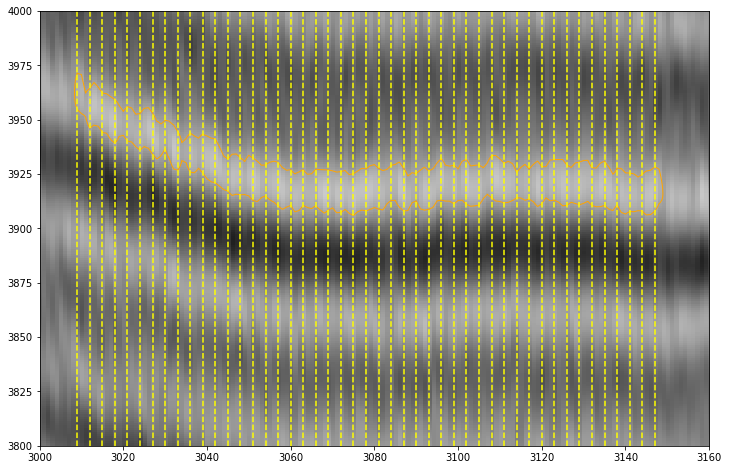

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

for x in uniquex[::3]:
    ax.axvline(x=x, color='yellow', linestyle='--')

plt.xlim([3000, 3160])
plt.ylim([3800, 4000])
    
plt.show()

In [16]:
saved_points2 = []
delete = []

for i, x in enumerate(uniquex):
    wherex = np.where(last_long_contours[1][:, 1]==x)[0]
    if len(wherex) == 0:
        delete.append(x)
    else:
        if len(wherex) > 2:
            saved_points2.append(wherex[1:3])
            #print(i, wherex[1:3])
        else:
            saved_points2.append(wherex)
            #print(i, wherex)
            
uniquex = [x for x in uniquex if x not in delete]
#print(len(uniquex))

### find y values, ridge points

In [17]:
ridge_points2 = []

In [18]:
for i, point in enumerate(saved_points2):
    if(len(point == 2)):
        idx3 = point[0]
        idx4 = point[1]
    elif(len(point > 2)):
        idx3 = point[1]
        idx4 = point[2]
    else:
        raise ValueException("You need to have at least two matching y-values.")
    
    x = uniquex[i]
    
    y1 = int(last_long_contours[1][idx3, 0])
    y2 = int(last_long_contours[1][idx4, 0])
    
    if len(data[y2:y1, x]) == 0:
        #print(i, x, np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
        ridge_points2.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
    else:
        #print(i, x, np.where(data[:, x] == np.max(data[y2:y1, x]))[0])
        ridge_points2.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])

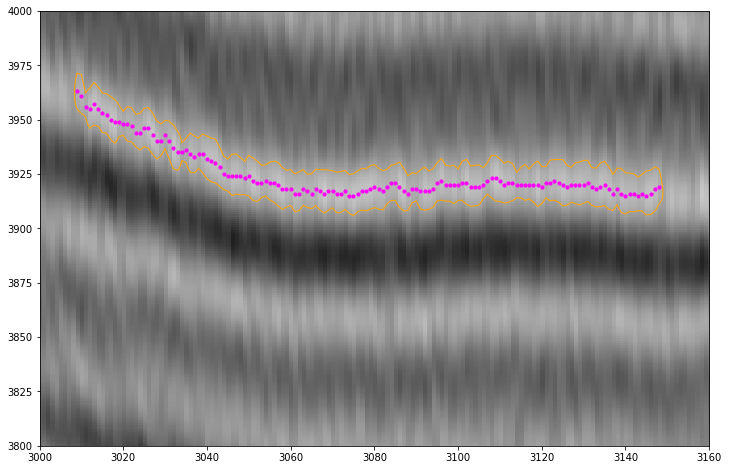

In [19]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)


for i, x in enumerate(uniquex):
    y = ridge_points2[i]
    ax.scatter(x, y, color='magenta', marker='o', s=10)
    
plt.xlim([3000, 3160])
plt.ylim([3800, 4000])

plt.show()

#### Now try to do for every point in `last_long_contours`

This means that we will need a list hold all of the ridge points for each contour. This is how this is going to work:
- find min and max x value for every contour: argx1, argx2 (<font color=red>Done!</font>)
- for every integer value in between those endpoint values, try to find what contour values are intersected there (<font color=red>Done!</font>)
- then find y values at those (hopefully two) points (<font color=red>Done!</font>)
- find ridge points (<font color=red>Done!</font>)
- find troughs? Needs work.

I either need to smooth the contours somehow, or figure something else out so that the ridge/trough structure is not so jumpy (mainly the troughs).

#### Missing `find_contours()` method, for finding the actual contours

In [20]:
def find_contour_points(contour, argx_list):
    #first try to save argx list
    argx1 = np.argmin(contour[:, 1])
    argx2 = np.argmax(contour[:, 1])
    argx_list.append([argx1, argx2])
    
    #find uniquex values for each contour
    uniquex = (list(set([int(x) for x in contour[:, 1]])))
    
    #get rid of x values that we don't have contour data for
    saved_points = []
    delete = []

    for x in uniquex:
        wherex = np.where(contour[:, 1] == x)[0]
        if len(wherex) == 0 or len(wherex) == 1:
            delete.append(x)
        else:
            if len(wherex) > 2:
                saved_points.append(wherex[1:3])
            else:
                saved_points.append(wherex)
    
    #delete values that we don't have enough data for
    uniquex = [x for x in uniquex if x not in delete]
    
    return uniquex, saved_points

In [21]:
def find_ridge_points(uniquex, saved_points, data, ridge_points):
    for i, point in enumerate(saved_points):
        if(len(point == 2)):
            idx1 = point[0]
            idx2 = point[1]
        elif(len(point > 2)):
            idx1 = point[1]
            idx2 = point[2]
        else:
            raise ValueException("You need to have at least two matching y-values.")

        x = uniquex[i]

        y1 = int(contour[idx1, 0])
        y2 = int(contour[idx2, 0])

        if len(data[y2:y1, x]) == 0:
            ridge_points.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
        else:
            ridge_points.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])
        
    return [elem[0] for elem in ridge_points]

In [22]:
def find_troughs(uniquex, ridge_points, data):
    maxrows, maxcols = np.shape(data)
    
    top, bottom = [], []
    temptop_idx, tempbottom_idx = [], []
    temptop_points, tempbottom_points = [], []

    for i, point in enumerate(uniquex):
        row = ridge_points[i]
        col = point

        #if the point holds a positive value, then we want to
        #find the troughs on either side of it
        if data[row, col] > 0:
            #look for top contour
            for j in range(row, maxrows):
                #enter the trough
                if (data[j, col] <= 0):
                    #print(j)
                    temptop_idx.append(j)
                    temptop_points.append(data[j, col])

                    #enterting this if statement would signify leaving the trough
                    if data[j+1, col] > 0:
                        #find the minimum in that column of the trough
                        trough_min = np.argmin(temptop_points)
                        top.append(temptop_idx[trough_min])

                        #reset these to empty for the next column
                        temptop_idx, temptop_points = [], []
                        break

            #look for bottom contour
            for k in range(0, row):
                #enter the trough
                if (data[row-k, col] <= 0):
                    tempbottom_idx.append(row-k)
                    tempbottom_points.append(data[row-k, col])

                    #enterting this if statement would signify leaving the trough
                    if data[row-k-1, col] > 0:
                        #find the minimum in that column of the trough
                        trough_bottom_min = np.argmin(tempbottom_points)
                        bottom.append(tempbottom_idx[trough_bottom_min])

                        #reset these to empty for the next column
                        tempbottom_idx, tempbottom_points = [], []
                        break


        #if the point holds a negative value, then we want to
        #find the peaks on either side of it
        else:
            pass
            #### NEED TO IMPLEMENT THE SAME THING FOR NEGATIVE CONTOURS #####

    return top, bottom

Eventually, this &#9660;&#9660;&#9660;&#9660; will need to be be its own method.

In [23]:
#save lists
argx_list = []
uniquex_list = []
saved_points_list = []

ridge_points_list = []
top, bottom = [], []
top_list, bottom_list = [], []

In [24]:
print(len(long_contours_pos))

333


In [25]:
for i, contour in enumerate(long_contours_pos):
    #get shape of data
    maxrows, maxcols = np.shape(data)
    
    #find x values for contour and where along that contour that x value occurs (aka, y values)
    uniquex, saved_points = find_contour_points(contour, argx_list)
    uniquex_list.append(uniquex)
    saved_points_list.append(saved_points)
        
    #find y values and ridge points for each contour
    ridge_points = []
    ridge = find_ridge_points(uniquex, saved_points, data, ridge_points)
    ridge_points_list.append(ridge)
    
    #find top and bottom troughs/peaks
    top, bottom = find_troughs(uniquex, ridge, data)
    top_list.append(top)
    bottom_list.append(bottom)
    
    print(i, argx_list[i], len(uniquex_list[i]), len(saved_points_list[i]), len(ridge_points_list[i]))

0 [5482, 0] 0 0 0
1 [0, 5789] 0 0 0
2 [6067, 0] 0 0 0
3 [0, 6101] 0 0 0
4 [6406, 0] 0 0 0
5 [0, 12317] 2178 2178 2178
6 [2330, 118] 1614 1614 1614
7 [207, 55] 83 83 83
8 [308, 151] 93 93 93
9 [149, 9] 76 76 76
10 [44399, 0] 4981 4981 4981
11 [774, 384] 237 237 237
12 [1168, 0] 738 738 738
13 [792, 278] 398 398 398
14 [568, 62] 380 380 380
15 [190, 54] 81 81 81
16 [497, 961] 265 265 265
17 [98, 696] 287 287 287
18 [161, 593] 241 241 241
19 [57, 277] 130 130 130
20 [88, 299] 64 64 64
21 [430, 2] 229 229 229
22 [1454, 0] 666 666 666
23 [6054, 12090] 4320 4320 4320
24 [31, 232] 108 108 108
25 [380, 2564] 721 721 721
26 [181, 369] 106 106 106
27 [5970, 11722] 4135 4135 4135
28 [968, 2134] 559 559 559
29 [3, 1259] 646 646 646
30 [403, 171] 53 53 53
31 [6773, 14001] 4246 4246 4246
32 [59, 1360] 662 662 662
33 [4018, 6631] 1927 1927 1927
34 [6751, 13543] 4257 4257 4257
35 [268, 746] 311 311 311
36 [96, 808] 517 517 517
37 [666, 1326] 278 278 278
38 [53, 1346] 665 665 665
39 [6541, 13093] 4262 

318 [13, 930] 240 240 240
319 [298, 574] 86 86 86
320 [154, 287] 53 53 53
321 [107, 240] 33 33 33
322 [127, 248] 28 28 28
323 [22, 175] 50 50 50
324 [10, 151] 38 38 38
325 [406, 847] 156 156 156
326 [427, 914] 181 181 181
327 [3, 166] 55 55 55
328 [9, 228] 80 80 80
329 [8, 232] 77 77 77
330 [5, 139] 35 35 35
331 [288, 664] 96 96 96
332 [882, 1653] 281 281 281


#### Why do the first 5 contours not have empty lists for uniquex, saved_points, and ridge_points?

Done processing contour 1/333
Done processing contour 2/333
Done processing contour 3/333
Done processing contour 4/333
Done processing contour 5/333
Done processing contour 6/333
Done processing contour 7/333
Done processing contour 8/333
Done processing contour 9/333
Done processing contour 10/333
Done processing contour 11/333
Done processing contour 12/333
Done processing contour 13/333
Done processing contour 14/333
Done processing contour 15/333
Done processing contour 16/333
Done processing contour 17/333
Done processing contour 18/333
Done processing contour 19/333
Done processing contour 20/333
Done processing contour 21/333
Done processing contour 22/333
Done processing contour 23/333
Done processing contour 24/333
Done processing contour 25/333
Done processing contour 26/333
Done processing contour 27/333
Done processing contour 28/333
Done processing contour 29/333
Done processing contour 30/333
Done processing contour 31/333


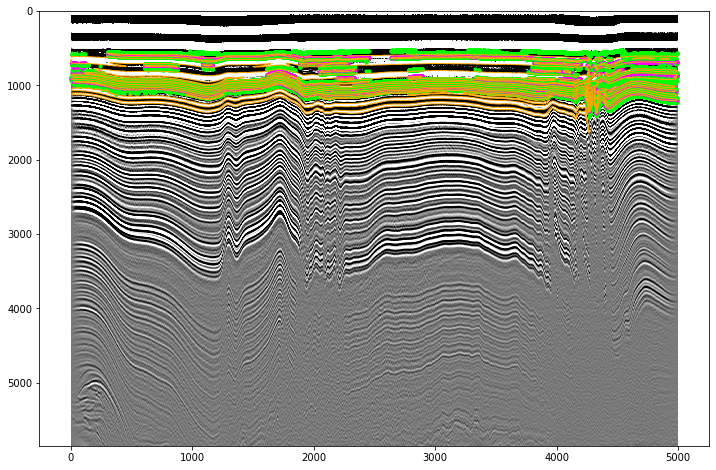

In [29]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

#plot grid
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(long_contours_pos[5:36]):
    #plot contours
    ax.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1)

    #plot ridge points
    ridge = ridge_points_list[i]
    uniqx = uniquex_list[i]
    top_ = top_list[i]
    bottom_ = bottom_list[i]
    
    for j, x in enumerate(uniqx):
        t = top_[j]
        r = ridge[j]
        b = bottom_[j]
        
        ax.scatter(x, t, color='lime', marker='o', s=10)
        ax.scatter(x, r, color='magenta', marker='o', s=10)
        ax.scatter(x, b, color='lime', marker='o', s=10)
        
    print('Done processing contour {}/{}'.format(i+1, len(long_contours_pos)))
        
plt.show()

<IPython.core.display.Javascript object>


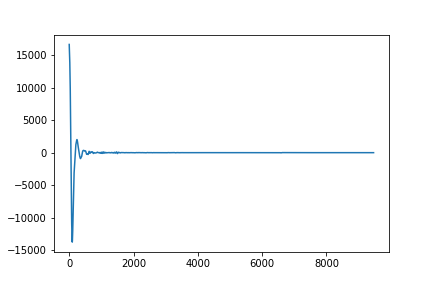

In [44]:
%matplotlib inline
plt.plot(data[:, 1000])
plt.show()

<IPython.core.display.Javascript object>


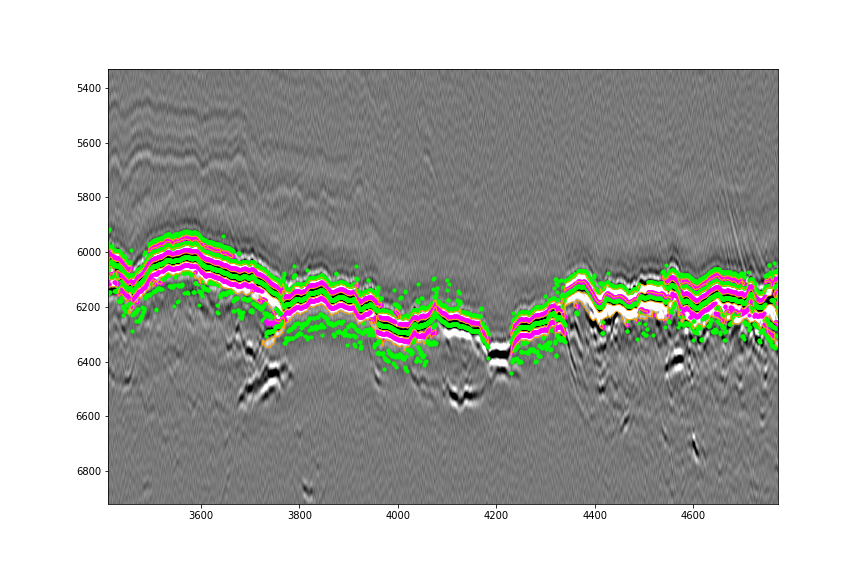

In [45]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

#plot grid
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(last_long_contours):
    #plot contours
    ax.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1)

    #plot ridge points
    ridge = ridge_points_list[i]
    uniqx = uniquex_list[i]
    top_ = top_list[i]
    bottom_ = bottom_list[i]
    
    for j, x in enumerate(uniqx):
        r = ridge[j]
        t = top_[j]
        b = bottom_[j]
        
        ax.scatter(x, r, color='magenta', marker='o', s=10)
        ax.scatter(x, t, color='lime', marker='o', s=10)
        ax.scatter(x, b, color='lime', marker='o', s=10)

ax.set_ylim(3400, 4800)
ax.set_ylim(6900, 5600)

plt.show()

Not ideal for the bed, but this method seems to work well for internal reflectors in the middle of the ice sheet. Ben mentioned putting constraints on the search, where we could give a frequency and (when converted to distance) only search from the ridge to that distance.

Some questions I have for this method:
- how could we determine a frequency to give to the algorithm automatically?
- what would happen if we didn't find anything? store a NaN value?
- what does that do to the average power along the sameples? **could use np.nanmean() and np.nansum()**

In [18]:
power = []

for i in range(len(ridge_points_list)):
    t_ = np.array(top_list[i])
    r_ = np.array(ridge_points_list[i])
    b_ = np.array(bottom_list[i])
    
    pick_power = np.mean(np.sum(t_**2 + r_**2 + b_**2))
    power.append(pick_power)

<IPython.core.display.Javascript object>


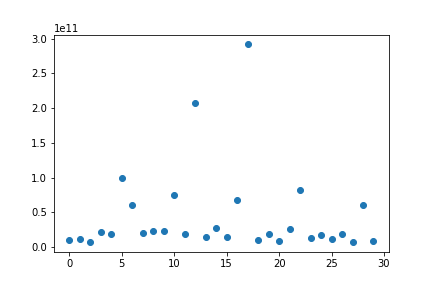

In [20]:
powerx = list(range(len(power)))

plt.scatter(powerx, power)

plt.show()

I wonder if we could separate the contours based on their power content. Bed picks have super low averaged power, then a layer above, and again for the contours above those.

Maybe cluster them into regimes of where they are in the ice?